# KPI Prediction - Company's Revenue & time series graph 5y back of quarterly periods


## Predicting spotify's revenue using web traffic and stock price
---
### <a style='color:red'> 30.05.2022 </a>


### Agenda
---
1. Predicting spotify's revenue using web traffic
    * Linear Regression
    * ReLU Approximation 
    * Iterative ReLU
2. From 1-dim input to 2-dim input by adding stock price information 
    * ReLU
    * Quadratic Regression

In [828]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

### Intro - Preprocessing the data
---
Let's first upload all the relevant data from our differents sources and store them successively into convenient data structures in order to plot them and then analyse them properly.\
We will :  
* Store our 'Sensor.csv' in a pandas.DataFrame and then retrieve some specific colomns and store them in numpy.Arrays by quarterly period
* Get the already quaterly segmented spotify's revenue and stock price from https://site.financialmodelingprep.com/developer/docs#Company-Financial-Statements 's API

In [885]:
# loading the csv into a dataframe

df = pd.read_csv('Sensor.csv',delimiter=';')

In [886]:
# we will focus on the worldwide web traffic of spotify

df_world_unsorted = df[df['Country']=='Worldwide']
df_world_unsorted["Date"] = pd.to_datetime(df_world_unsorted["Date"])
df_world = df_world_unsorted.sort_values(by="Date")

/opt/anaconda3/envs/deep_learning/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [887]:
# get quarterly web traffic for 5 years 

users_per_month_arr = df_world['Total Users'].tail(60).to_numpy()
users_per_quarter_arr = np.zeros(20)
for i, _ in enumerate(users_per_quarter_arr):
    users_per_quarter_arr[i] = users_per_month_arr[i*3] + users_per_month_arr[i*3+1] + users_per_month_arr[i*3+2]
    users_per_quarter_arr[i] = float(users_per_quarter_arr[i])  

In [888]:
# get quaterly revenue and stock price for 5 years

try:
    # For Python 3.0 and later
    from urllib.request import urlopen
except ImportError:
    # Fall back to Python 2's urllib2
    from urllib2 import urlopen

import certifi
import json

def get_jsonparsed_data(url):
    """
    Receive the content of ``url``, parse it as JSON and return the object.

    Parameters
    ----------
    url : str

    Returns
    -------
    dict
    """
    response = urlopen(url, cafile=certifi.where())
    data = response.read().decode("utf-8")
    return json.loads(data)

url_income = ("https://financialmodelingprep.com/api/v3/income-statement/SPOT?period=quarter&limit=20&apikey=d8bff17163e5a0cb653b05576c608e2b")
data_income = get_jsonparsed_data(url_income)

revenue_per_quarter = np.zeros(20)
date_per_quarter = np.empty(20, dtype=object)

url_stock = ("https://financialmodelingprep.com/api/v3/enterprise-values/SPOT?period=quarter&limit=20&apikey=d8bff17163e5a0cb653b05576c608e2b")
data_stock = get_jsonparsed_data(url_stock)

stock_per_quarter = np.zeros(20)
value_per_quarter = np.zeros(20)
stock_per_quarter = np.zeros(20)

for i, quarter_element in enumerate(data_income) :
    revenue_per_quarter[19-i] = quarter_element['revenue']
    date_per_quarter[19-i] = quarter_element['date']
    
for i, quarter_element in enumerate(data_stock) :
    value_per_quarter[19-i] = quarter_element['enterpriseValue']
    stock_per_quarter[19-i] = quarter_element['stockPrice']


/opt/anaconda3/envs/deep_learning/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.


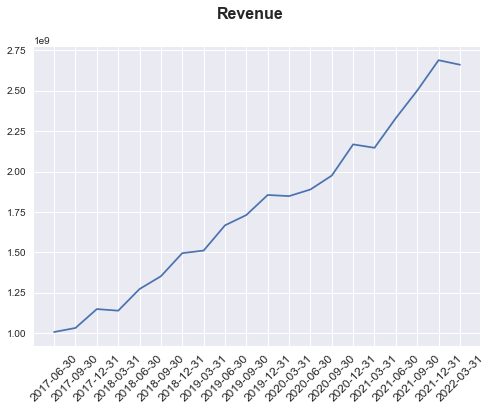

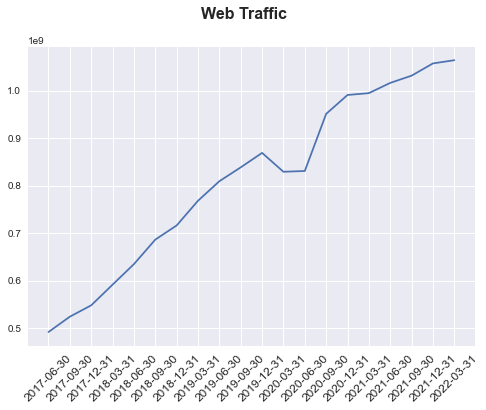

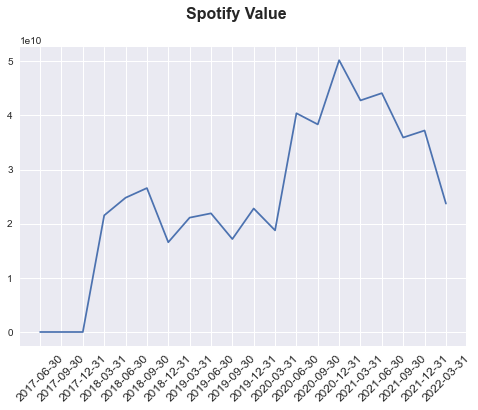

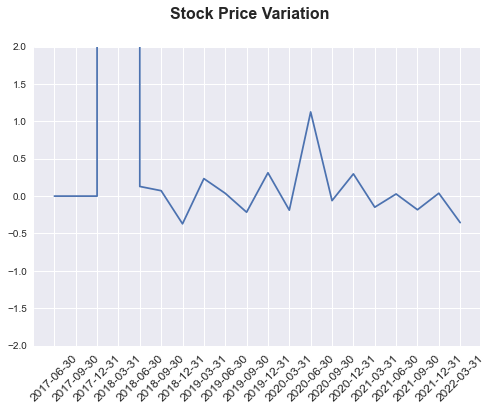

In [889]:
fig, ax1 = plt.subplots()
fig.suptitle('Revenue', fontsize=16, fontweight="bold")

ax1.plot(date_per_quarter,revenue_per_quarter)
ax1.tick_params(axis='x', which='major', labelsize=12, rotation=45)

fig, ax2 = plt.subplots()
fig.suptitle('Web Traffic', fontsize=16, fontweight="bold")

ax2.plot(date_per_quarter,users_per_quarter_arr)
ax2.tick_params(axis='x', which='major', labelsize=12, rotation=45)

fig, ax3 = plt.subplots()
fig.suptitle('Spotify Value', fontsize=16, fontweight="bold")

ax3.plot(date_per_quarter,value_per_quarter)
ax3.tick_params(axis='x', which='major', labelsize=12, rotation=45)

fig, ax4 = plt.subplots()
fig.suptitle('Stock Price Variation', fontsize=16, fontweight="bold")

stock_per_quarter[value_per_quarter==0] = 0.001

stock_pct_change_arr = np.diff(stock_per_quarter) / stock_per_quarter[:-1]

ax4.plot(date_per_quarter,np.concatenate(([0],stock_pct_change_arr)))
ax4.tick_params(axis='x', which='major', labelsize=12, rotation=45)
ax4.set_ylim([-2, 2]);

## Part 1 - Predicting spotify's revenue using web traffic

### Linear Regression 
---
Let's now try to find some correlation between those data sets.\
My intuition would be that we should find some high correlation between the web traffic and the revenue. Generally speaking, the number of users should automatically go with the number of subscribtions, since revenue is the the total amount of income generated by the company. The more you sell, the higher is your revenue. Ok, this sounds pretty linear. Let's plot the two to be sure :

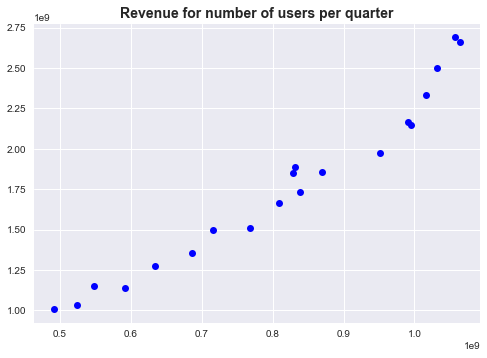

In [890]:
plt.style.use('seaborn')
fig, ax = plt.subplots()
ax.plot(users_per_quarter_arr, revenue_per_quarter,'bo')
ax.set_title('Revenue for number of users per quarter', fontsize=14,fontweight='heavy')
plt.show()

In [893]:
x_train = users_per_quarter_arr[0:-4]
x_train = x_train.reshape(-1, 1)/pow(10,8)

x_test = users_per_quarter_arr[-4:20]
x_test = x_test.reshape(-1, 1)/pow(10,8)

y_train = revenue_per_quarter[0:-4]
y_train = y_train.reshape(-1, 1)/pow(10,8)

y_test = revenue_per_quarter[-4:20]
y_test = y_test.reshape(-1, 1)/pow(10,8)

In [894]:
torch.set_default_dtype(torch.float64)
from torch.autograd import Variable
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [896]:
inputDim = 1        # takes variable 'x' 
outputDim = 1       # takes variable 'y'
learningRate = 0.01 
epochs = 1000

model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

In [897]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
loss_list = []
loss_test_list = []

In [898]:
for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train).cuda())
        labels = Variable(torch.from_numpy(y_train).cuda())
    else:
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)
    outputs_test = model(Variable(torch.from_numpy(x_test)))

    # get loss for the predicted output
    previous_loss = loss 
    loss = criterion(outputs, labels)
    loss_test = criterion(outputs_test, Variable(torch.from_numpy(y_test)))
    loss_list.append(loss.item())
    loss_test_list.append(loss_test.item())
    
    #print(loss)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()
    
    print('epoch {}, loss {}'.format(epoch, loss.item()))
    
    #if abs(loss.item() - previous_loss.item()) < 0.0001:
        #break


epoch 0, loss 320.8711085534351
epoch 1, loss 14.618152638913728
epoch 2, loss 1.3519031955973615
epoch 3, loss 0.7766546956375848
epoch 4, loss 0.7511300651539587
epoch 5, loss 0.7494182519224701
epoch 6, loss 0.748738913122664
epoch 7, loss 0.7481052947287201
epoch 8, loss 0.7474746528994037
epoch 9, loss 0.7468451345019216
epoch 10, loss 0.7462166576264032
epoch 11, loss 0.7455892170879032
epoch 12, loss 0.7449628110275825
epoch 13, loss 0.7443374377333749
epoch 14, loss 0.7437130955022593
epoch 15, loss 0.7430897826342961
epoch 16, loss 0.7424674974323553
epoch 17, loss 0.7418462382021072
epoch 18, loss 0.7412260032520137
epoch 19, loss 0.7406067908933337
epoch 20, loss 0.7399885994400963
epoch 21, loss 0.7393714272091222
epoch 22, loss 0.7387552725200047
epoch 23, loss 0.7381401336951023
epoch 24, loss 0.7375260090595455
epoch 25, loss 0.7369128969412242
epoch 26, loss 0.7363007956707834
epoch 27, loss 0.7356897035816239
epoch 28, loss 0.7350796190098876
epoch 29, loss 0.734470540

epoch 345, loss 0.5846107582994355
epoch 346, loss 0.5842497600320926
epoch 347, loss 0.5838893569484405
epoch 348, loss 0.5835295480671916
epoch 349, loss 0.5831703324086721
epoch 350, loss 0.5828117089948293
epoch 351, loss 0.5824536768492166
epoch 352, loss 0.5820962349970036
epoch 353, loss 0.581739382464961
epoch 354, loss 0.581383118281471
epoch 355, loss 0.58102744147651
epoch 356, loss 0.5806723510816592
epoch 357, loss 0.580317846130094
epoch 358, loss 0.5799639256565838
epoch 359, loss 0.5796105886974932
epoch 360, loss 0.5792578342907697
epoch 361, loss 0.5789056614759516
epoch 362, loss 0.578554069294157
epoch 363, loss 0.5782030567880885
epoch 364, loss 0.5778526230020253
epoch 365, loss 0.5775027669818219
epoch 366, loss 0.5771534877749052
epoch 367, loss 0.5768047844302747
epoch 368, loss 0.5764566559984976
epoch 369, loss 0.5761091015317061
epoch 370, loss 0.5757621200835932
epoch 371, loss 0.5754157107094148
epoch 372, loss 0.5750698724659836
epoch 373, loss 0.57472460

epoch 692, loss 0.4891607825543769
epoch 693, loss 0.4889571542082245
epoch 694, loss 0.4887538615874243
epoch 695, loss 0.48855090413846214
epoch 696, loss 0.488348281308733
epoch 697, loss 0.488145992546546
epoch 698, loss 0.4879440373011175
epoch 699, loss 0.4877424150225744
epoch 700, loss 0.4875411251619485
epoch 701, loss 0.48734016717117484
epoch 702, loss 0.4871395405030974
epoch 703, loss 0.48693924461145605
epoch 704, loss 0.4867392789508975
epoch 705, loss 0.4865396429769617
epoch 706, loss 0.4863403361460902
epoch 707, loss 0.4861413579156193
epoch 708, loss 0.4859427077437798
epoch 709, loss 0.4857443850896976
epoch 710, loss 0.4855463894133859
epoch 711, loss 0.4853487201757543
epoch 712, loss 0.4851513768385973
epoch 713, loss 0.48495435886459604
epoch 714, loss 0.4847576657173203
epoch 715, loss 0.48456129686122296
epoch 716, loss 0.48436525176163847
epoch 717, loss 0.48416952988478673
epoch 718, loss 0.48397413069776396
epoch 719, loss 0.48377905366854485
epoch 720, lo

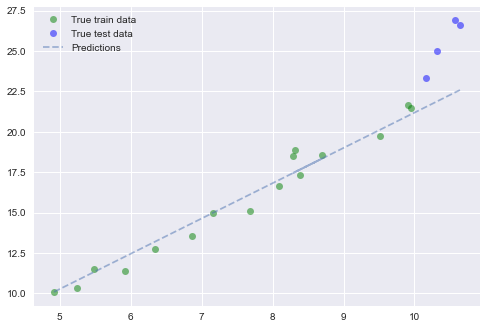

test loss =  12.265195106493126


In [899]:
with torch.no_grad(): # we don't need gradients in the testing phase
    if torch.cuda.is_available():
        predicted = model(Variable(torch.from_numpy(np.concatenate((x_train,x_test))).cuda())).cpu().data.numpy()
    else:
        predicted = model(Variable(torch.from_numpy(np.concatenate((x_train,x_test))))).data.numpy()

plt.clf()
plt.plot(x_train, y_train, 'go', label='True train data', alpha=0.5)
plt.plot(x_test, y_test, 'bo', label='True test data', alpha=0.5)
plt.plot(np.concatenate((x_train,x_test)), predicted, '--', label='Predictions', alpha=0.5)


plt.legend(loc='best')
plt.show()
print('test loss = ',loss_test.item())

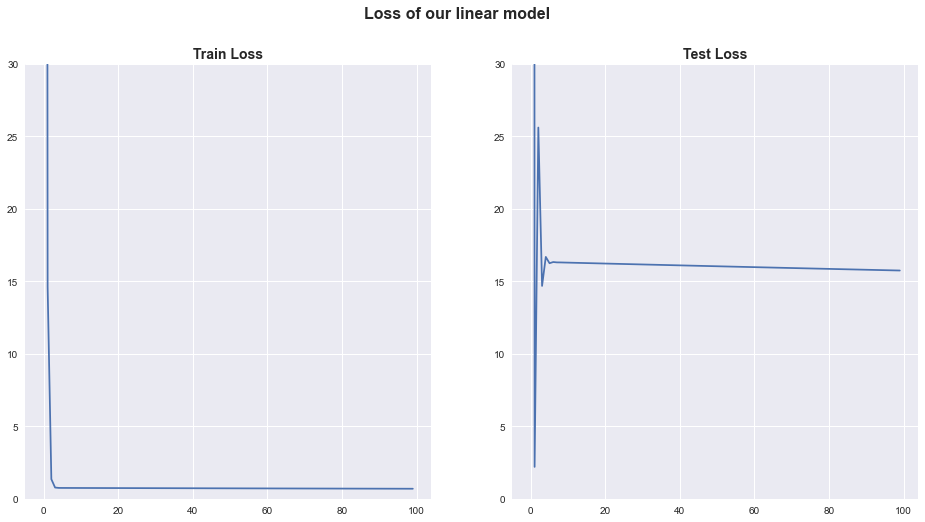

In [900]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (16, 8))
fig.suptitle('Loss of our linear model', fontsize=16, fontweight="bold")

ax1.plot(np.arange(0, 100, 1),loss_list[0:100])
ax1.set_ylim([0, 30])
ax2.plot(np.arange(0, 100, 1), loss_test_list[0:100])
ax2.set_ylim([0, 30])

ax1.set_title('Train Loss', fontsize=14,fontweight='heavy')
ax2.set_title('Test Loss', fontsize=14, fontweight='heavy' );

Okay. Our model fits very well our train set. Unfortunately it doesn't do a great job at predicting our test set. Using a linear model wasn't that of a bad idea but here's the problem : the test set (last 4 quarters) looks on a very different dynamic than the train set! if we had taken the train data between 2017 and 2020 and the test data between 2020 and 2021, we would have had great results.\
For our current case, our model may be too linear. Let's try to add some non linearity with reLU, so it could catch some changes in the dynamic.

### ReLU Approximation 

In [928]:
x_train = users_per_quarter_arr[0:-4]
x_train = x_train.reshape(-1, 1)/pow(10,8)

x_test = users_per_quarter_arr[-4:20]
x_test = x_test.reshape(-1, 1)/pow(10,8)

x = users_per_quarter_arr
x = x.reshape(-1, 1)/pow(10,8)

y_train = revenue_per_quarter[0:-4]
y_train = y_train.reshape(-1, 1)/pow(10,8)

y_test = revenue_per_quarter[-4:20]
y_test = y_test.reshape(-1, 1)/pow(10,8)

y = revenue_per_quarter
y = y.reshape(-1, 1)/pow(10,8)

In [929]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   
        self.predict = torch.nn.Linear(n_hidden, n_output)  

    def forward(self, x):
        x = F.relu(self.hidden(x))      
        x = self.predict(x)             
        return x

In [930]:
inputDim = 1        # takes variable 'x' 
outputDim = 1       # takes variable 'y'
num_hidden = 100
learningRate = 0.01
epochs = 1000

model = Net(inputDim, num_hidden, outputDim) 
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

In [931]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)

loss_list = []
loss_test_list = []

In [932]:
for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train).cuda())
        labels = Variable(torch.from_numpy(y_train).cuda())
    else:
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)
    outputs_test = model(Variable(torch.from_numpy(x_test)))

    # get loss for the predicted output
    previous_loss = loss 
    loss = criterion(outputs, labels)
    loss_test = criterion(outputs_test, Variable(torch.from_numpy(y_test)))
    loss_list.append(loss.item())
    loss_test_list.append(loss_test.item())
    
    #print(loss)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()
    
    print('epoch {}, loss {}'.format(epoch, loss.item()))
    
    #if loss.item() == previous_loss.item():
        #break

epoch 0, loss 277.1753133379153
epoch 1, loss 1774.422070677614
epoch 2, loss 73.48127362316472
epoch 3, loss 127.73498147915916
epoch 4, loss 345.92680066134346
epoch 5, loss 380.6609355733918
epoch 6, loss 331.42398875322596
epoch 7, loss 264.38568477270576
epoch 8, loss 213.55228164423335
epoch 9, loss 177.6755236189214
epoch 10, loss 148.07459877272908
epoch 11, loss 119.09616395340356
epoch 12, loss 87.27622161507641
epoch 13, loss 52.978704658865844
epoch 14, loss 21.464465118038476
epoch 15, loss 2.578059721593651
epoch 16, loss 5.364128188774808
epoch 17, loss 27.612732859512207
epoch 18, loss 50.40638826277553
epoch 19, loss 53.02025493338316
epoch 20, loss 34.24417179935487
epoch 21, loss 11.851139240905434
epoch 22, loss 1.552510767940899
epoch 23, loss 3.1104966139074515
epoch 24, loss 10.709057770397497
epoch 25, loss 17.60689807319477
epoch 26, loss 20.137562005616502
epoch 27, loss 17.23320414242234
epoch 28, loss 10.773501712917303
epoch 29, loss 4.306988193696949
epoch

epoch 421, loss 0.3656535674896062
epoch 422, loss 0.3656535674896741
epoch 423, loss 0.3656535674897365
epoch 424, loss 0.36565356748979516
epoch 425, loss 0.3656535674898487
epoch 426, loss 0.3656535674898965
epoch 427, loss 0.3656535674899355
epoch 428, loss 0.3656535674899689
epoch 429, loss 0.36565356748999445
epoch 430, loss 0.3656535674900145
epoch 431, loss 0.36565356749002753
epoch 432, loss 0.3656535674900354
epoch 433, loss 0.36565356749003763
epoch 434, loss 0.3656535674900355
epoch 435, loss 0.3656535674900274
epoch 436, loss 0.36565356749001643
epoch 437, loss 0.3656535674900032
epoch 438, loss 0.36565356748998573
epoch 439, loss 0.36565356748996586
epoch 440, loss 0.3656535674899448
epoch 441, loss 0.36565356748992117
epoch 442, loss 0.3656535674898962
epoch 443, loss 0.3656535674898712
epoch 444, loss 0.3656535674898451
epoch 445, loss 0.3656535674898185
epoch 446, loss 0.3656535674897925
epoch 447, loss 0.36565356748976663
epoch 448, loss 0.3656535674897412
epoch 449, 

epoch 840, loss 0.36565356748932565
epoch 841, loss 0.36565356748932565
epoch 842, loss 0.36565356748932487
epoch 843, loss 0.3656535674893253
epoch 844, loss 0.3656535674893253
epoch 845, loss 0.365653567489325
epoch 846, loss 0.3656535674893252
epoch 847, loss 0.36565356748932576
epoch 848, loss 0.3656535674893252
epoch 849, loss 0.3656535674893259
epoch 850, loss 0.36565356748932587
epoch 851, loss 0.36565356748932515
epoch 852, loss 0.36565356748932587
epoch 853, loss 0.3656535674893259
epoch 854, loss 0.3656535674893252
epoch 855, loss 0.36565356748932526
epoch 856, loss 0.36565356748932526
epoch 857, loss 0.3656535674893252
epoch 858, loss 0.365653567489326
epoch 859, loss 0.365653567489326
epoch 860, loss 0.3656535674893255
epoch 861, loss 0.3656535674893254
epoch 862, loss 0.3656535674893254
epoch 863, loss 0.36565356748932576
epoch 864, loss 0.3656535674893252
epoch 865, loss 0.36565356748932554
epoch 866, loss 0.36565356748932554
epoch 867, loss 0.3656535674893253
epoch 868, 

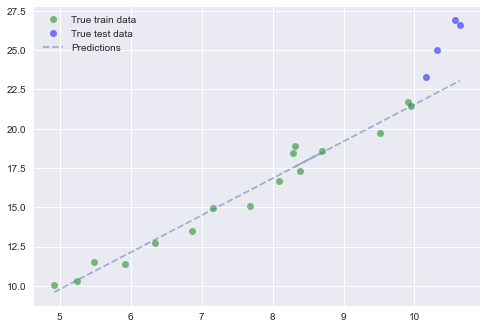

test loss =  9.496968317507847


In [933]:
with torch.no_grad(): # we don't need gradients in the testing phase
    if torch.cuda.is_available():
        predicted = model(Variable(torch.from_numpy(np.concatenate((x_train,x_test))).cuda())).cpu().data.numpy()
    else:
        predicted = model(Variable(torch.from_numpy(np.concatenate((x_train,x_test))))).data.numpy()

plt.clf()
plt.plot(x_train, y_train, 'go', label='True train data', alpha=0.5)
plt.plot(x_test, y_test, 'bo', label='True test data', alpha=0.5)
plt.plot(np.concatenate((x_train,x_test)), predicted, '--', label='Predictions', alpha=0.5)


plt.legend(loc='best')
plt.show()
print('test loss = ', loss_test.item())

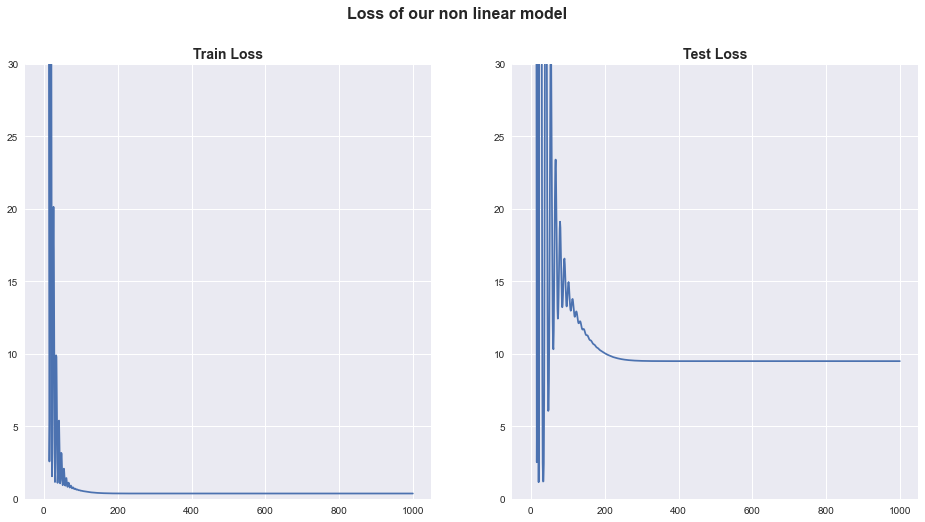

In [934]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (16, 8))
fig.suptitle('Loss of our non linear model', fontsize=16, fontweight="bold")

ax1.plot(np.arange(0, 1000, 1),loss_list[0:1000])
ax1.set_ylim([0, 30])
ax2.plot(np.arange(0, 1000, 1), loss_test_list[0:1000])
ax2.set_ylim([0, 30])

ax1.set_title('Train Loss', fontsize=14,fontweight='heavy')
ax2.set_title('Test Loss', fontsize=14, fontweight='heavy' );

We got the same phenomenon. But now it's even a little worst : our model takes even more iterations to converge to   the same loss.\
The prediction is basically the same! It predicted a linear relation, althought we added non linearity. That can be explained by the linearity of our test set. Let's find some way to improve our analysis.

### Iterative ReLU Approximation 
---
Let's make our model less theorical and more practical. Why should we predict the revenue 4 quarters in advance? Let's predict only one quarter and then use its real output to re-train our model and predict the next one .. 

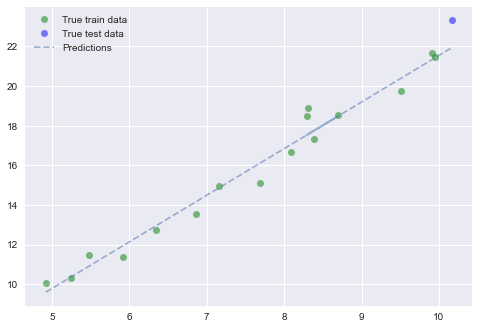

test loss for blue dot =  1.912115622782419


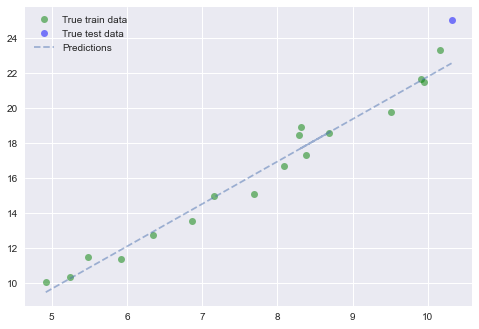

test loss for blue dot =  6.004670362742687


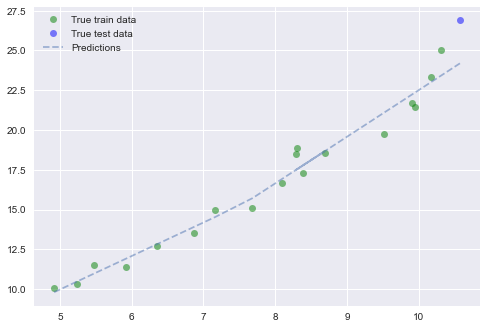

test loss for blue dot =  7.284175540244828


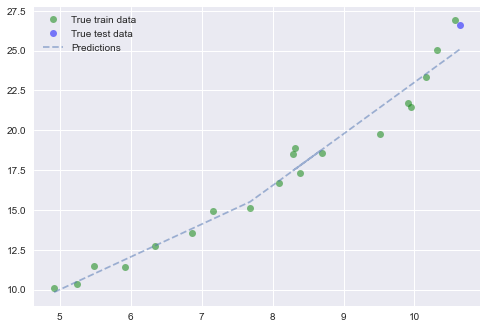

test loss for blue dot =  2.314459278956028


In [937]:
x_train = users_per_quarter_arr[0:-4]
x_train = x_train.reshape(-1, 1)/pow(10,8)

x_test = users_per_quarter_arr[-4:20]
x_test = x_test.reshape(-1, 1)/pow(10,8)

x = users_per_quarter_arr
x = x.reshape(-1, 1)/pow(10,8)

y_train = revenue_per_quarter[0:-4]
y_train = y_train.reshape(-1, 1)/pow(10,8)

y_test = revenue_per_quarter[-4:20]
y_test = y_test.reshape(-1, 1)/pow(10,8)

y = revenue_per_quarter
y = y.reshape(-1, 1)/pow(10,8)

loss_test_list = []
x_test_size = len(x_test)

for i in range(x_test_size):
    
    inputDim = 1        # takes variable 'x' 
    outputDim = 1       # takes variable 'y'
    num_hidden = 100
    learningRate = 0.01
    epochs = 1000

    model = Net(inputDim, num_hidden, outputDim) 
    ##### For GPU #######
    if torch.cuda.is_available():
        model.cuda()
    
    criterion = torch.nn.MSELoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.2)

    loss_list = []
    for epoch in range(epochs):
        # Converting inputs and labels to Variable
        if torch.cuda.is_available():
            inputs = Variable(torch.from_numpy(x_train).cuda())
            labels = Variable(torch.from_numpy(y_train).cuda())
        else:
            inputs = Variable(torch.from_numpy(x_train))
            labels = Variable(torch.from_numpy(y_train))

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(inputs)
        outputs_test = model(Variable(torch.from_numpy(x_test[i])))

        # get loss for the predicted output
        previous_loss = loss 
        loss = criterion(outputs, labels)
        loss_test = criterion(outputs_test, Variable(torch.from_numpy(y_test[i])))
        loss_list.append(loss.item())

        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

        #print('epoch {}, loss {}'.format(epoch, loss.item()))
        
        
    with torch.no_grad(): # we don't need gradients in the testing phase
        if torch.cuda.is_available():
            predicted = model(Variable(torch.from_numpy(np.concatenate((x_train,[x_test[i]]))).cuda())).cpu().data.numpy()
        else:
            predicted = model(Variable(torch.from_numpy(np.concatenate((x_train,[x_test[i]]))))).data.numpy()
            
    plt.clf()
    plt.plot(x_train, y_train, 'go', label='True train data', alpha=0.5)
    plt.plot(x_test[i], y_test[i], 'bo', label='True test data', alpha=0.5)
    plt.plot(np.concatenate((x_train,[x_test[i]])), predicted, '--', label='Predictions', alpha=0.5)


    plt.legend(loc='best')
    plt.show()
    print('test loss for blue dot = ', loss_test.item())
    loss_test_list.append(loss_test.item())
    
    x_train = np.concatenate((x_train,[x_test[i]]))
    y_train = np.concatenate((y_train,[y_test[i]]))

In [938]:
print('cumulated MSE = ',sum(loss_test_list)/4)

cumulated MSE =  4.378855201181491


Although our iterative reLU functions could have been more curvy in order to match our target even more (especially in iteration 1 and 2), our cumulated MSE is better than the ones obtained before! 

## Part 2 - From 1-dim input to 2-dim input by adding stock price information 

If linearity between web traffic and revenue seemed to be the most logical thing to suppose, it appeares that it is not always the case, and that some other parameters are reponsible for non-linear component, such as the sudden change in the linear relation from the train set to the test set. Why does the revenue suddenly grows much faster than before in respect to the web traffic? Which means : why are the current customers less visiting the website? Are the new customers not conviced by the quality of the product ? Or is it a general trend among all streaming plateform?\
Despite those unsolved problems, website traffic still proved to be a good leading indicator, with a good correlation to the revenue, and should certainely be used on more sophisticated model. But using it as the only leading indicator made our model too rigid, leaving no space to uncertainty and human behavioral randomness.\
That's why, in the following section, I wanted to introduce in the model, some information about the stock price (I intended to use variation as you can see in the preprocessing section).\
But unfortunately I couldn't complete it in time ...